In [1]:
import fdasrsf as fs
import fdasrsf.utility_functions as uf
from scipy.linalg import norm
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [23]:
data_num = 20
residential_f = np.zeros((8760, 20))

for i in range(0,data_num):
    filename = 'auunal_curve_20/' + str(i+1) + '.csv'
    data = np.genfromtxt(filename, delimiter=',')
    residential_f[:,i] = data[1:None,1]
residential_f = np.float64(residential_f)
time = np.arange(1,8760+1)
time = np.float64(time)

reduced_f = np.zeros((1095, 20))
reduced_f[:,:] = residential_f[0:1095,:]
reduced_time = time[0:1095]
residential_f = reduced_f
time = reduced_time

residential_obj = fs.fdawarp(residential_f, time)
residential_obj.srsf_align(smoothdata=False,parallel=True,MaxItr=50)

ncompv = 20
ncomph = 20
nsample = data_num
N = len(time)

Initializing...
Compute Karcher Mean of 20 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
updating step: r=21
updating step: r=22
updating step: r=23
updating step: r=24
updating step: r=25
updating step: r=26
updating step: r=27
updating step: r=28
updating step: r=29
updating step: r=30
updating step: r=31
updating step: r=32
updating step: r=33
updating step: r=34
updating step: r=35
updating step: r=36
updating step: r=37
updating step: r=38
updating step: r=39
updating step: r=40
updating step: r=41
updating step: r=42
updating step: r=43
updating step: r=44
updating step: r=45
updating step: r=46
updating step: r=47


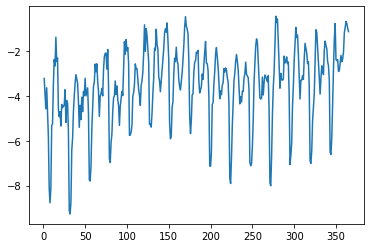

In [21]:

plt.figure()
plt.plot(time[0:365], reduced_f[:,0])

In [4]:
residential_data = np.genfromtxt('hourly_demand/RESIDENT.csv', delimiter=',')
residential_f = np.transpose(residential_data[1:None,1].reshape(365,24))
residential_f = np.float64(residential_f)
time = np.arange(1,25)
time = np.float64(time)

residential_obj = fs.fdawarp(residential_f, time)
residential_obj.srsf_align(smoothdata=False,parallel=True,MaxItr=150)

ncompv = 5
ncomph = 5
nsample = 365
N = len(time)

Initializing...
Compute Karcher Mean of 365 function in SRSF space...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
updating step: r=21
updating step: r=22
updating step: r=23
updating step: r=24
updating step: r=25
updating step: r=26
updating step: r=27
updating step: r=28
updating step: r=29
updating step: r=30
updating step: r=31
updating step: r=32
updating step: r=33
updating step: r=34
updating step: r=35
updating step: r=36
updating step: r=37
updating step: r=38
updating step: r=39
updating step: r=40
updating step: r=41
updating step: r=42
updating step: r=43
updating step: r=44
updating step: r=45
updating step: r=46
updating step: r=47

In [5]:
print(residential_f.shape)

(24, 365)


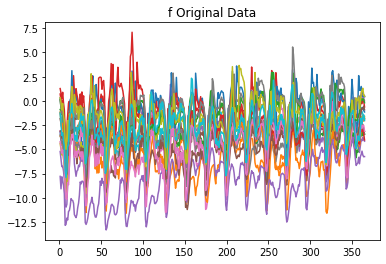

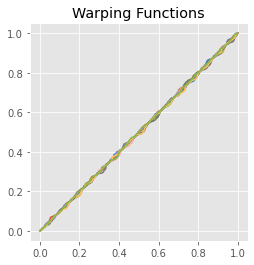

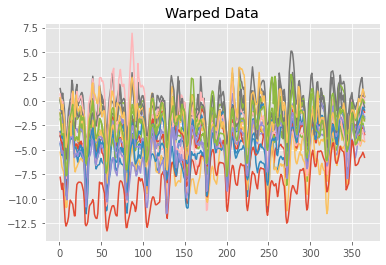

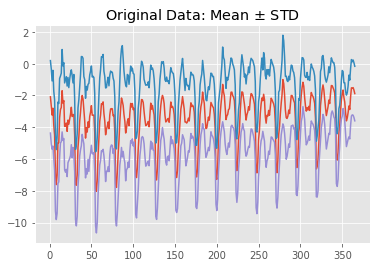

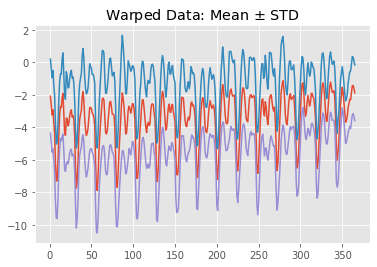

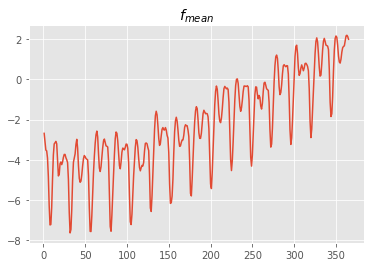

In [24]:
residential_obj.plot()

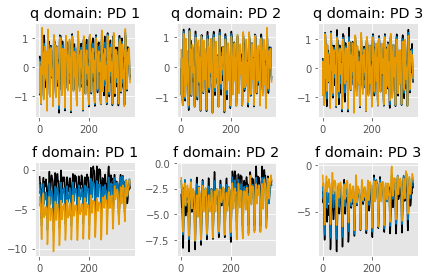

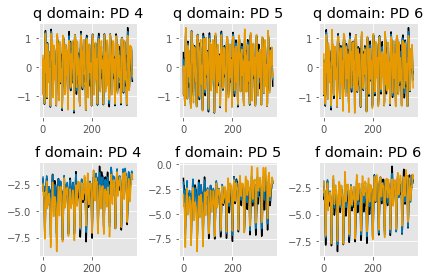

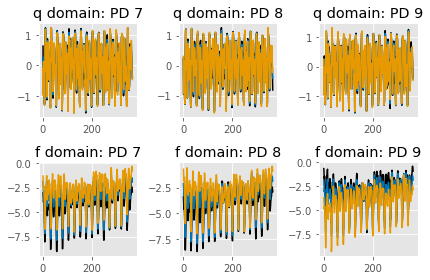

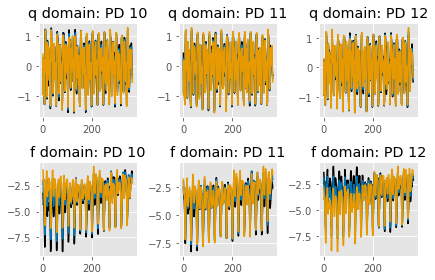

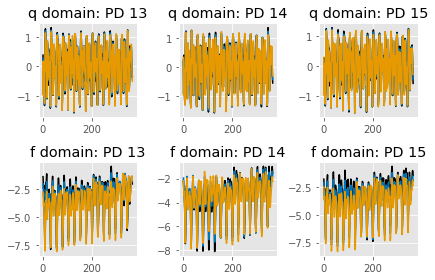

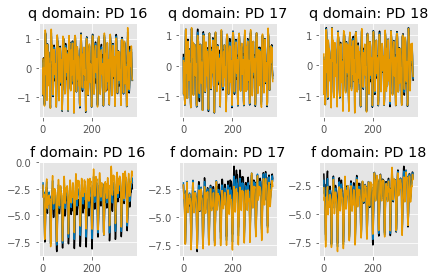

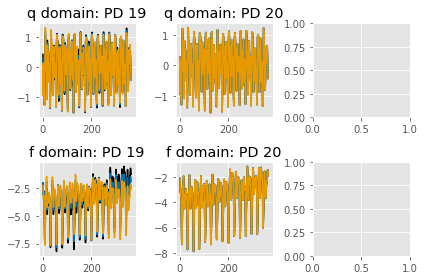

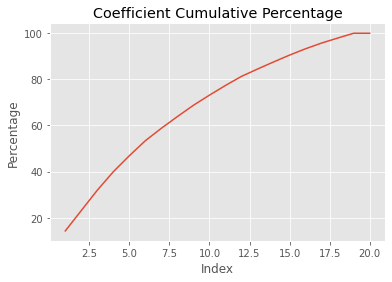

In [25]:
residential_vpca = fs.fdavpca(residential_obj)
residential_vpca.calc_fpca(no=ncompv)
residential_vpca.plot()

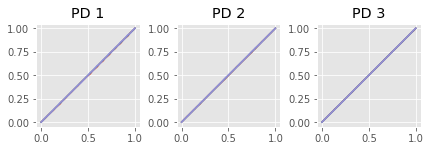

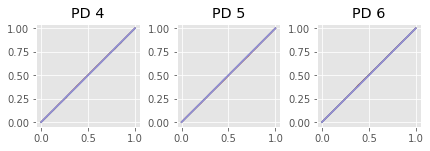

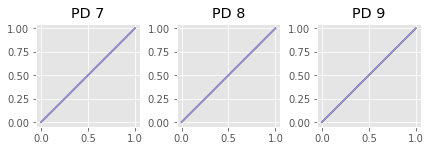

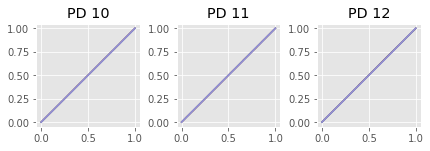

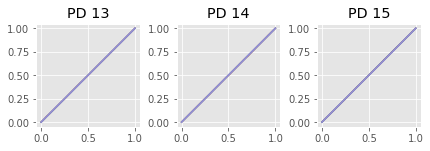

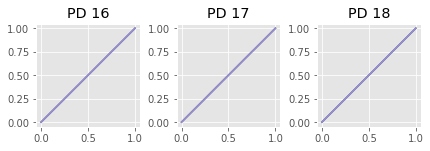

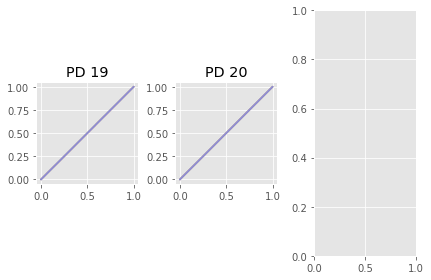

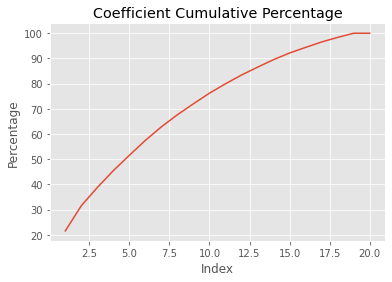

In [26]:
residential_hpca = fs.fdahpca(residential_obj)
residential_hpca.calc_fpca(no=ncomph)
residential_hpca.plot()

In [27]:
# Recover aligned function fn, from vpca
vpca_U = residential_vpca.U
vpca_mqn = residential_vpca.mqn
vpca_coef = residential_vpca.coef

midid = int(np.round(len(time)/2))

qns = np.ndarray(shape=(len(vpca_mqn), nsample))

for i in range(0, nsample):
    qns[:,i] = vpca_mqn
    for j in range(0, ncompv):
        qns[:,i] = qns[:,i] + vpca_coef[i,j]*vpca_U[:,j]

f_m = uf.cumtrapzmid(time, vpca_mqn[0:N] * np.abs(vpca_mqn[0:N]), np.sign(vpca_mqn[N]) * (vpca_mqn[N] ** 2), midid)

f_s = np.ndarray(shape=(len(vpca_mqn)-1, nsample))
for i in range(0, nsample):
    f_s[:,i] = uf.cumtrapzmid(time, qns[0:N,i] * np.abs(qns[0:N,i]), np.sign(qns[N,i]) * (qns[N,i] ** 2), midid+1)

#Recover warpping function gamma, from hpca
hpca_U = residential_hpca.U
hpca_coef = residential_hpca.coef
hpca_mu = residential_hpca.psi_mu

vs = np.ndarray(shape=(hpca_U.shape[0], nsample))
psis = np.ndarray(shape=(hpca_U.shape[0], nsample))
gams = np.ndarray(shape=(hpca_U.shape[0], nsample))

for i in range(0, nsample):
    vs[:,i] = 0
    for j in range(0, ncomph):
        vs[:,i] = vs[:,i] + hpca_coef[i,j]*hpca_U[:,j]
    vn = norm(vs[:,i]) / np.sqrt(N)
    if vn < 0.0001:
        psis[:,i] = hpca_mu
    else:
        psis[:,i] = np.cos(vn)*hpca_mu + np.sin(vn)*vs[:,i]/vn
    tmp = cumtrapz(psis[:,i]*psis[:,i], np.linspace(0,1,N), initial=0)
    gams[:,i] = (tmp - tmp[0]) / (tmp[-1] - tmp[0])

#Recover original function f, from recovered fn and gamma
f_rec = np.ndarray(shape=(hpca_U.shape[0], nsample))
for i in range(0, nsample):
    f_rec[:,i] = uf.warp_f_gamma(gams[:,i], f_s[:,i], np.linspace(0,1,N))

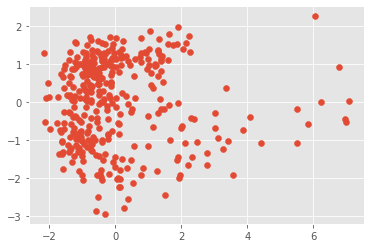

In [62]:
plt.figure(999)
#plt.plot(vpca_coef[:,1], vpca_coef[:,2])
plt.scatter(vpca_coef[:,0], vpca_coef[:,1])

In [37]:
print(hpca_coef.shape)

(365, 5)


In [38]:
from copula import pyCopula
vpca_coef_list = []
for i in range(0, vpca_coef.shape[0]):
    vpca_coef_list.append(vpca_coef[i,:].tolist())

vpca_cop = pyCopula.Copula(vpca_coef_list)
vpca_samples_list = vpca_cop.gendata(365)
#print(vpca_samples)

vpca_samples = np.asarray(vpca_samples_list)

hpca_coef_list = []
for i in range(0, hpca_coef.shape[0]):
    hpca_coef_list.append(hpca_coef[i,:].tolist())

hpca_cop = pyCopula.Copula(hpca_coef_list)
hpca_samples_list = hpca_cop.gendata(365)
#print(vpca_samples)

hpca_samples = np.asarray(hpca_samples_list)

Exception: Data not suitable for Copula. Covarience of two column is 0

(20, 20)


ValueError: x and y must have same first dimension, but have shapes (365,) and (20,)

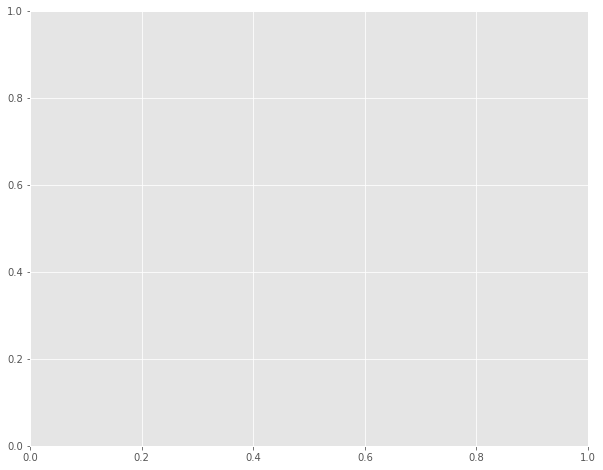

In [28]:
print(vpca_coef.shape)
for i in range(0, vpca_coef.shape[1]):
    plt.figure(num=100+i, figsize=[10, 8])
    plt.plot(np.arange(1,366), vpca_coef[:,i])
    plt.scatter(np.arange(1,366), vpca_coef[:,i])
    title = 'score_plots/MED_v_pc' + str(i+1) + '.png'
    plt.savefig(title)

(366, 20)


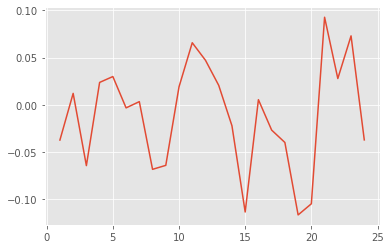

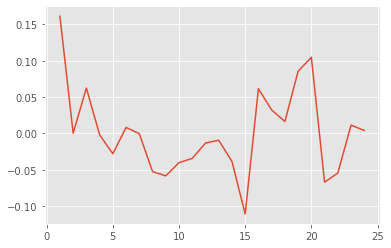

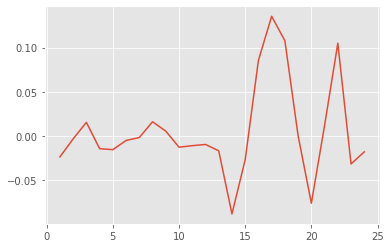

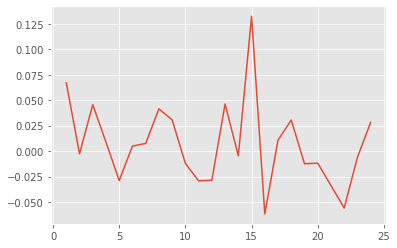

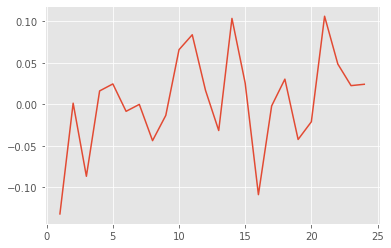

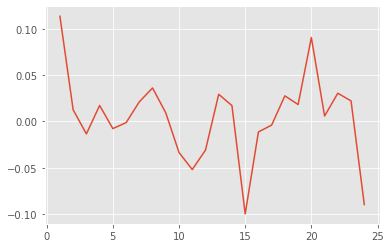

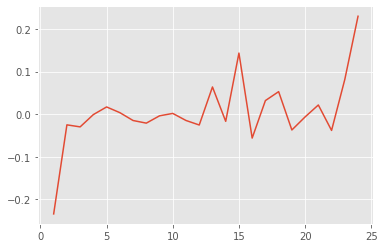

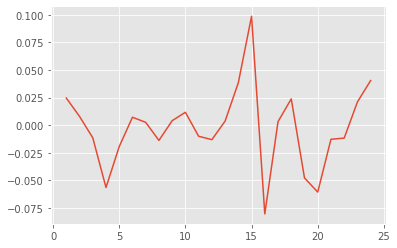

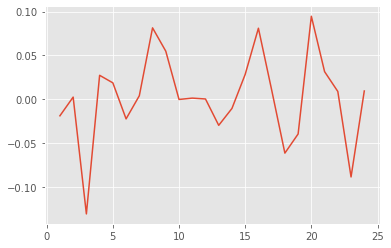

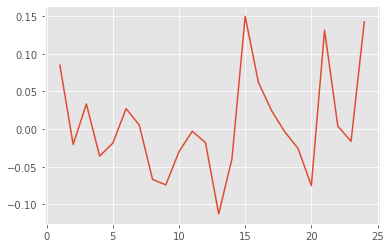

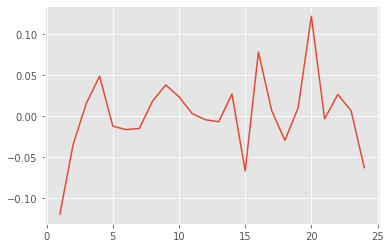

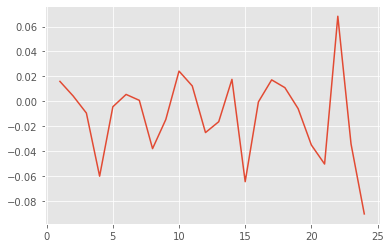

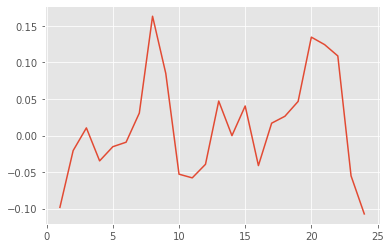

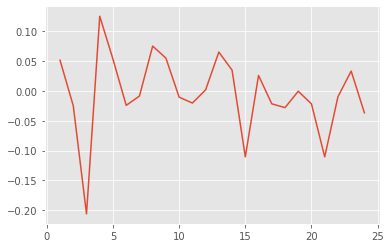

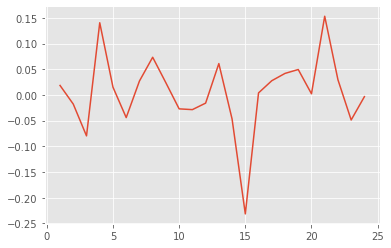

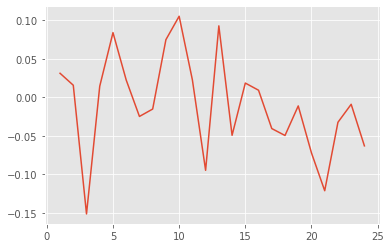

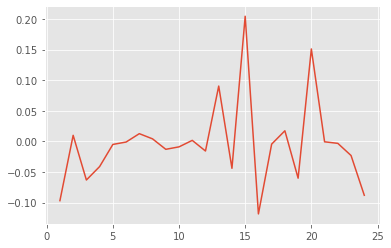

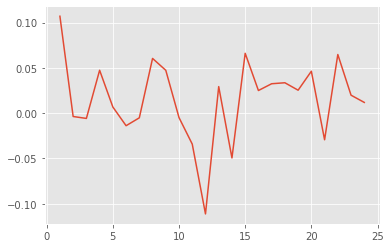

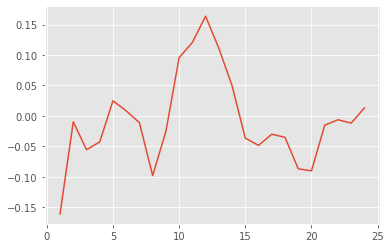

In [29]:
print(vpca_U.shape)
for i in range(0, vpca_U.shape[1]-1):
    plt.figure(150+i)
    plt.plot(np.arange(1,25), vpca_U[0:24,i])

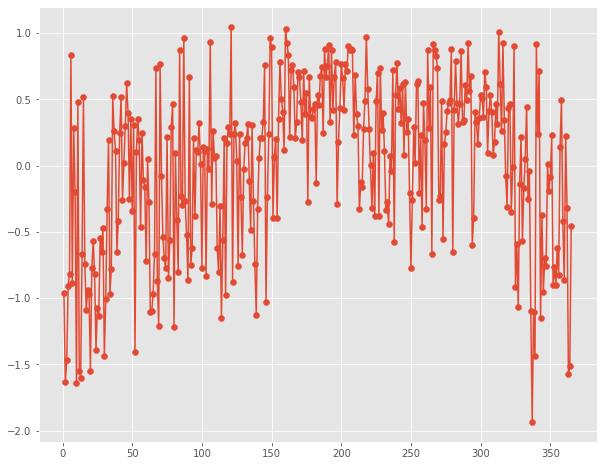

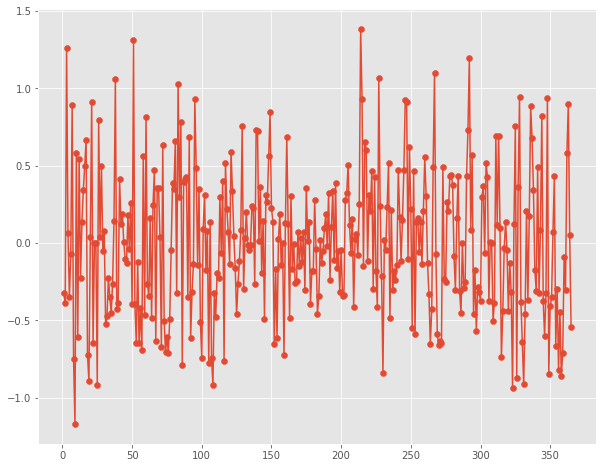

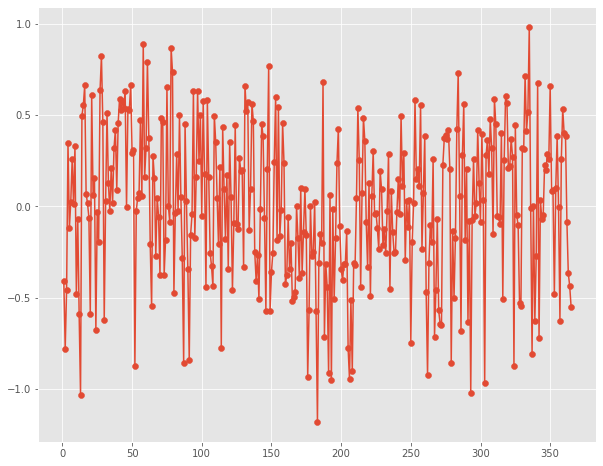

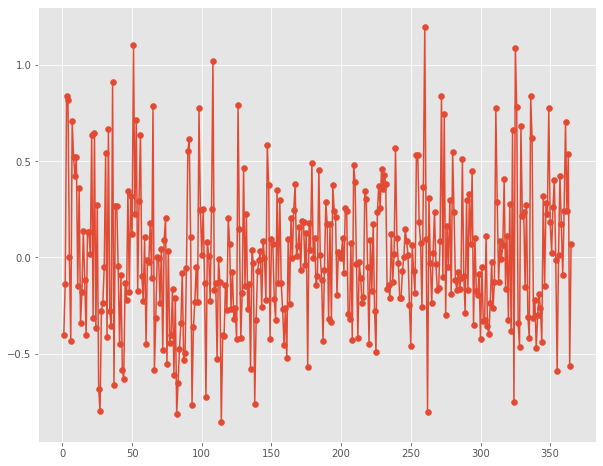

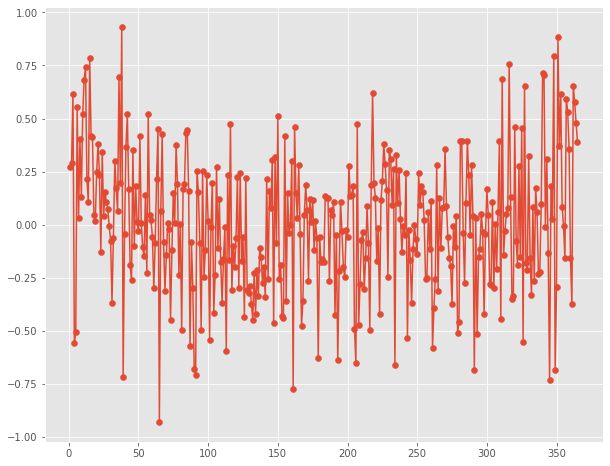

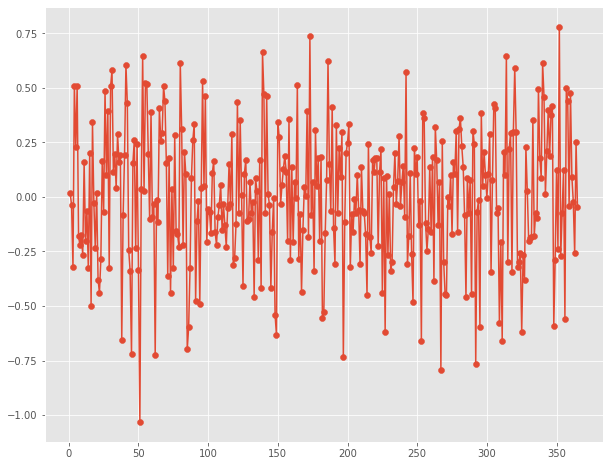

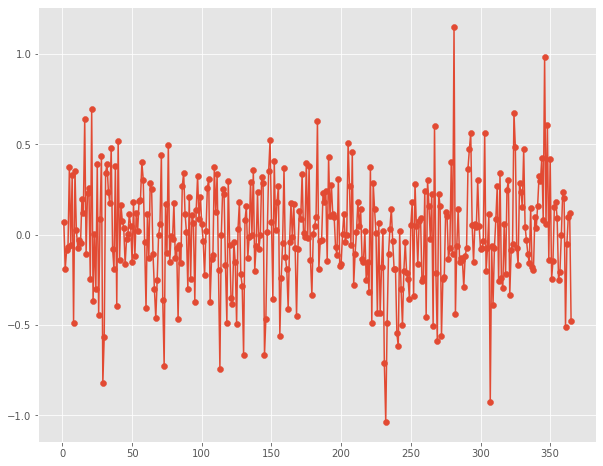

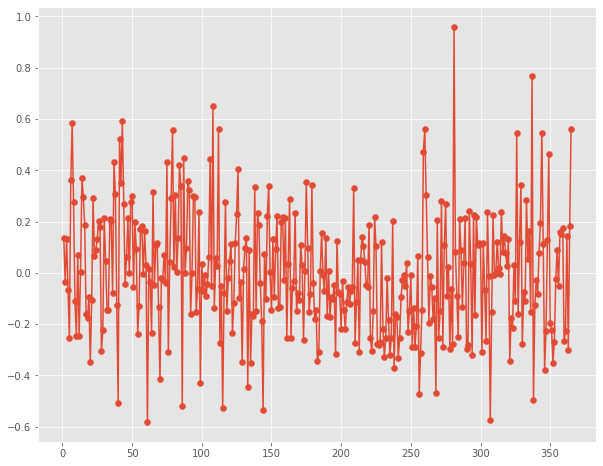

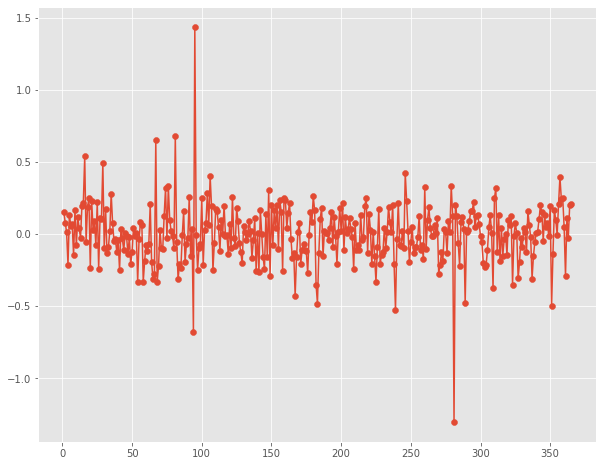

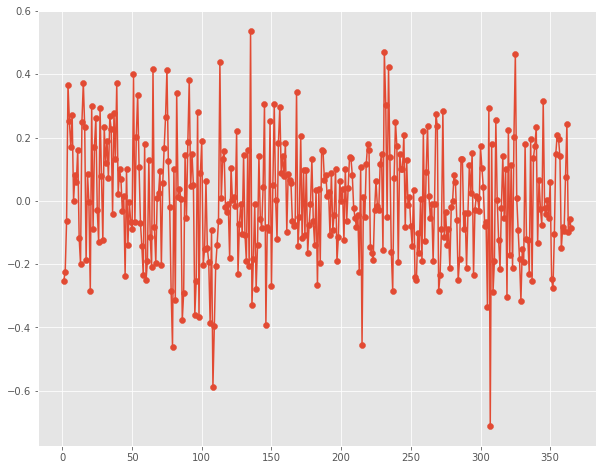

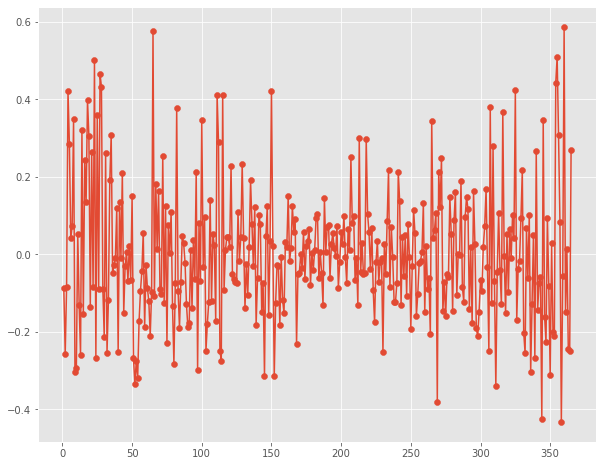

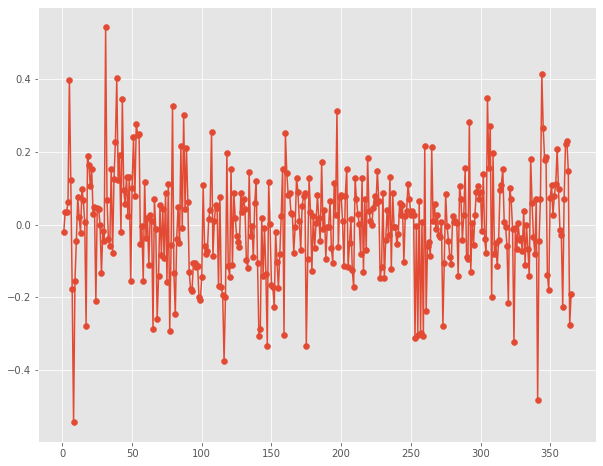

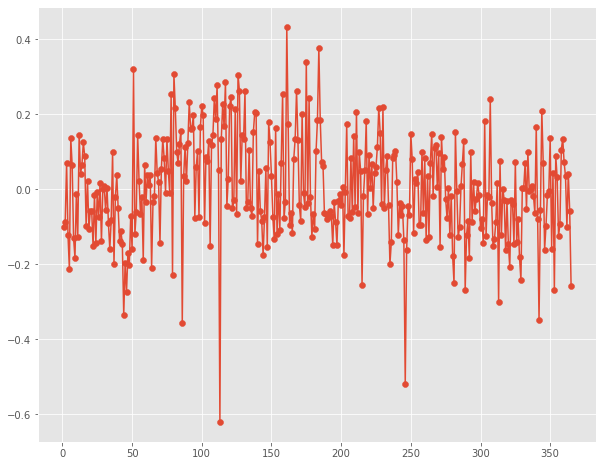

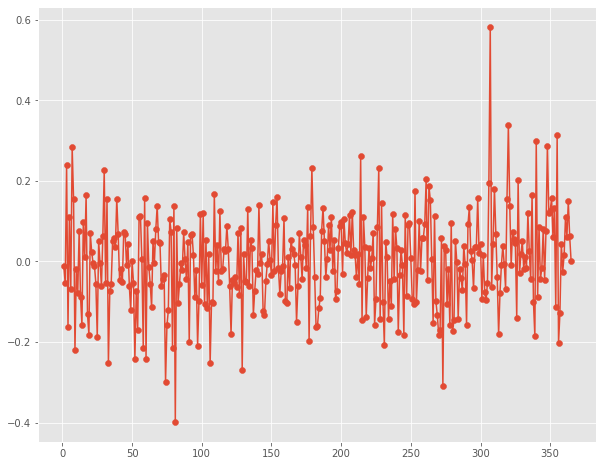

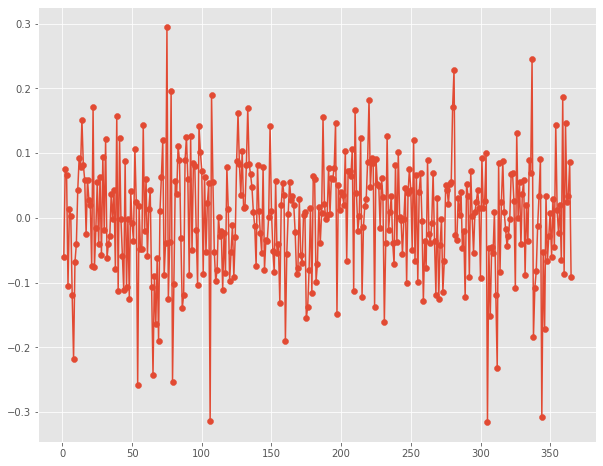

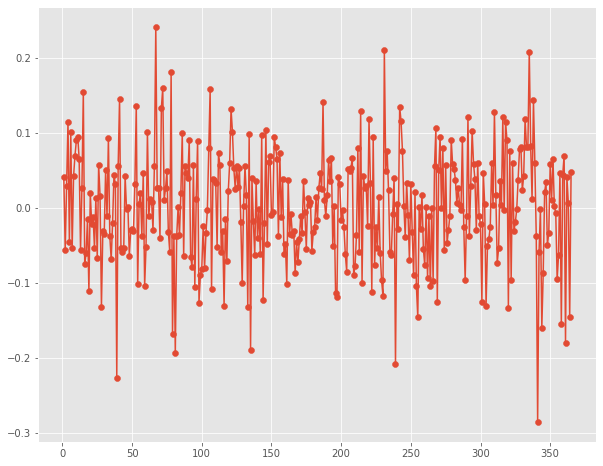

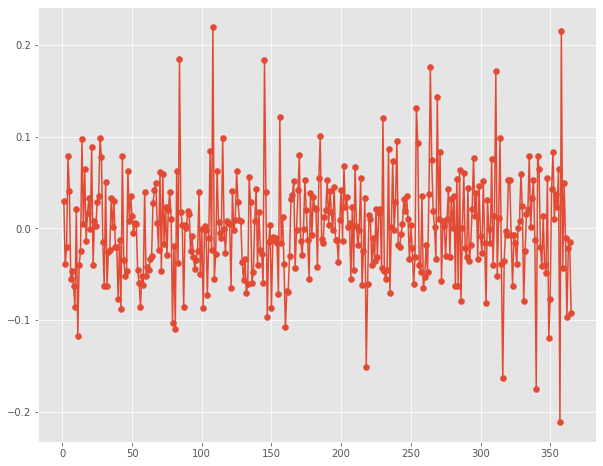

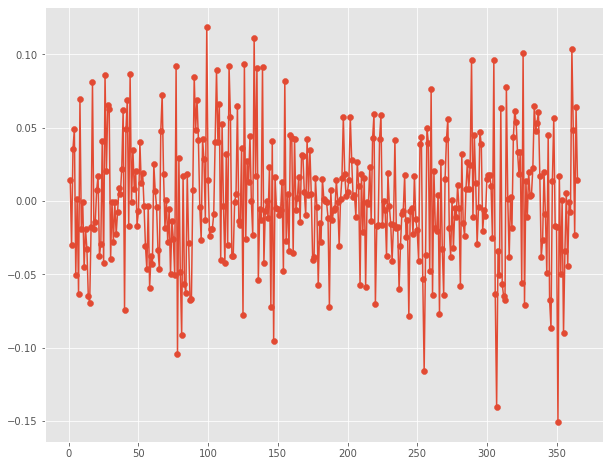

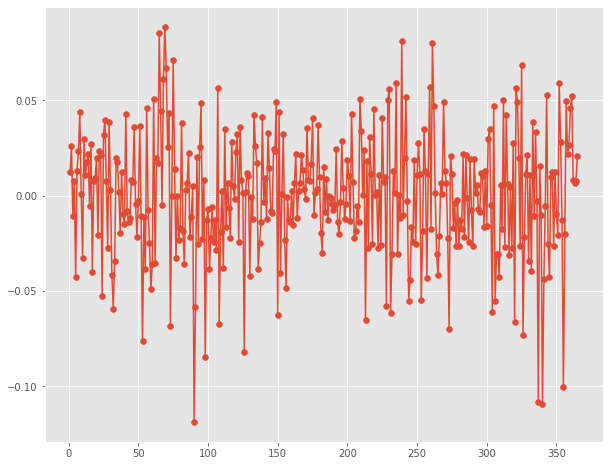

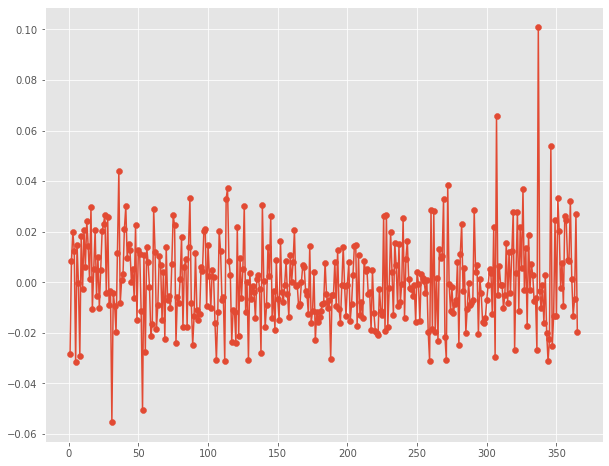

In [45]:
for i in range(0, hpca_coef.shape[1]):
    plt.figure(num=150+i, figsize=[10, 8])
    plt.plot(np.arange(1,366), hpca_coef[:,i])
    plt.scatter(np.arange(1,366), hpca_coef[:,i])
    title = 'score_plots/MED_h_pc' + str(i+1) + '.png'
    plt.savefig(title)

In [30]:
#Get data before fpca
o_qn = residential_obj.qn
o_fn = residential_obj.fn
o_vec = residential_hpca.vec
o_gam = residential_obj.gam
o_f = residential_obj.f

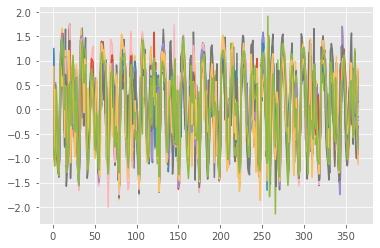

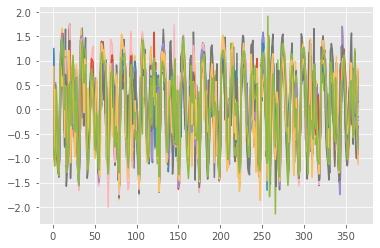

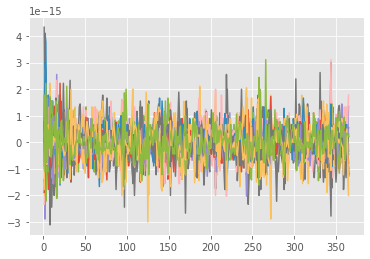

In [31]:
#Plot original qn
plt.figure(101)
for i in range(0,nsample):
    plt.plot(time,o_qn[:,i])
#plt.savefig('plots/qn_ori.png')

#Plot recovered qn
plt.figure(102)
for i in range(0,nsample):
    plt.plot(time,qns[0:N,i])
#plt.savefig('plots/qn_rec.png')

#Plot difference between original and recovered data
plt.figure(103)
for i in range(0,nsample):
    plt.plot(time,o_qn[:,i] - qns[0:N,i])
#plt.savefig('plots/qn_err.png')

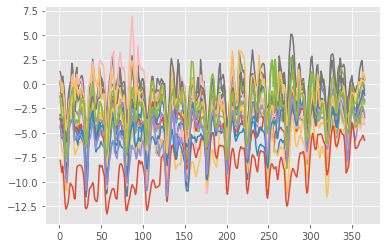

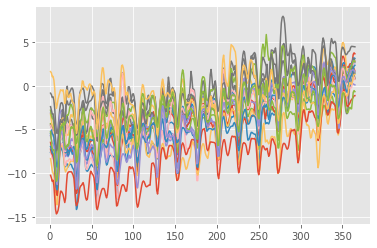

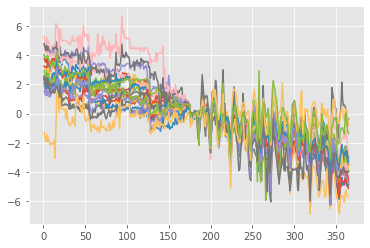

In [32]:
#Plot original fn
plt.figure(104)
for i in range(0,nsample):
    plt.plot(time,o_fn[:,i])
#plt.savefig('plots/fn_ori.png')

#Plot recovered fn
plt.figure(105)
for i in range(0,nsample):
    plt.plot(time,f_s[:,i])
#plt.savefig('plots/fn_rec.png')
    
#Plot difference between original and recovered data
plt.figure(106)
for i in range(0,nsample):
    plt.plot(time,o_fn[:,i] - f_s[:,i])
#plt.savefig('plots/fn_err.png')

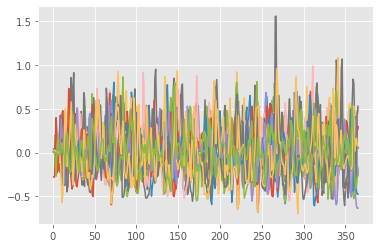

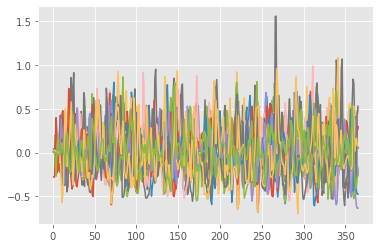

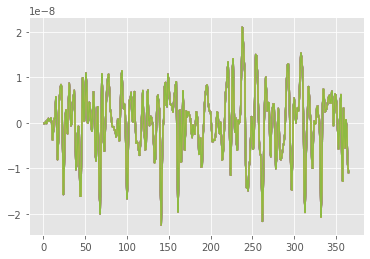

In [33]:
#Plot original vec
plt.figure(201)
for i in range(0,nsample):
    plt.plot(time,o_vec[:,i])
#plt.savefig('plots/v_ori.png')

#Plot recovered vec
plt.figure(202)
for i in range(0,nsample):
    plt.plot(time,vs[:,i])
#plt.savefig('plots/v_rec.png')

#Plot difference between original and recovered data
plt.figure(203)
for i in range(0,nsample):
    plt.plot(time,o_vec[:,i] - vs[:,i])
#plt.savefig('plots/v_err.png')

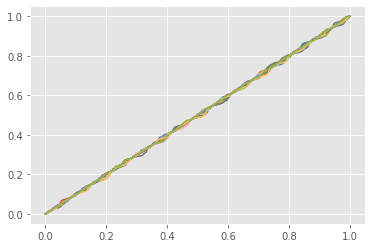

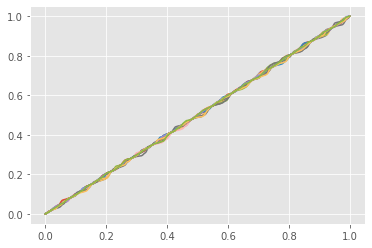

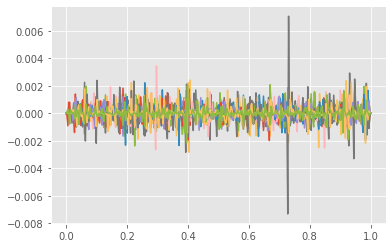

In [34]:
#Plot original gam
plt.figure(204)
for i in range(0,nsample):
    plt.plot(np.linspace(0,1,N),o_gam[:,i])
#plt.savefig('plots/gam_ori.png')

#Plot recovered gam
plt.figure(205)
for i in range(0,nsample):
    plt.plot(np.linspace(0,1,N),gams[:,i])
#plt.savefig('plots/gam_rec.png')

#Plot difference between original and recovered data
plt.figure(206)
for i in range(0,nsample):
    plt.plot(np.linspace(0,1,N),o_gam[:,i] - gams[:,i])
#plt.savefig('plots/gam_err.png')

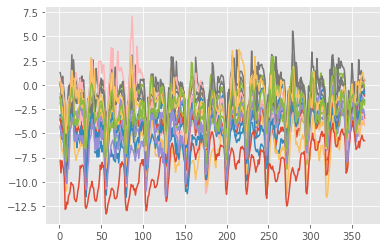

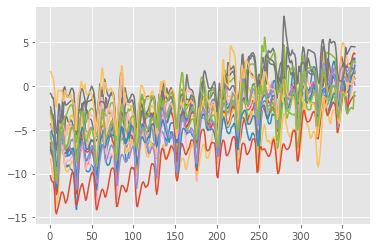

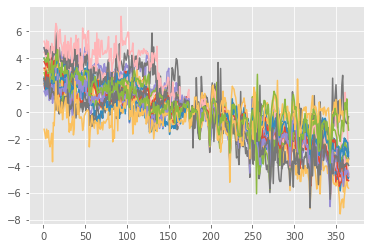

In [35]:
#Plot original f
plt.figure(301)
for i in range(0,nsample):
    plt.plot(time,o_f[:,i])
#plt.savefig('plots/f_ori.png')

#Plot recovered f
plt.figure(302)
for i in range(0,nsample):
    plt.plot(time,f_rec[:,i])
#plt.savefig('plots/f_rec.png')

#Plot difference between original and recovered data
plt.figure(303)
for i in range(0,nsample):
    plt.plot(time,o_f[:,i] - f_rec[:,i])
#plt.savefig('plots/f_err.png')

In [41]:
def demand_generation(num, in_vpca, in_hpca):
    #Get vpca data
    vpca_U = in_vpca.U
    vpca_mqn = in_vpca.mqn
    vpca_coef = in_vpca.coef
    midid = int(np.round(len(time)/2))
    #Get hpca data
    hpca_U = in_hpca.U
    hpca_coef = in_hpca.coef
    hpca_mu = in_hpca.psi_mu
    
    opt_bw_v = []
    opt_bw_h = []
    
    gen_vcoef = np.ndarray(shape=(num,vpca_coef.shape[1]))
    gen_qn = np.ndarray(shape=(len(vpca_mqn), num))
    gen_fn = np.ndarray(shape=(len(vpca_mqn)-1, num))
    
    gen_hcoef = np.ndarray(shape=(num,hpca_coef.shape[1]))
    gen_v = np.ndarray(shape=(hpca_U.shape[0], num))
    gen_psi = np.ndarray(shape=(hpca_U.shape[0], num))
    gen_gam = np.ndarray(shape=(hpca_U.shape[0], num))
    
    gen_f = np.ndarray(shape=(hpca_U.shape[0], num))
    
    
    gen_qn2 = np.ndarray(shape=(len(vpca_mqn), num))
    gen_fn2 = np.ndarray(shape=(len(vpca_mqn)-1, num))
    gen_v2 = np.ndarray(shape=(hpca_U.shape[0], num))
    gen_psi2 = np.ndarray(shape=(hpca_U.shape[0], num))
    gen_gam2 = np.ndarray(shape=(hpca_U.shape[0], num))
    gen_f2 = np.ndarray(shape=(hpca_U.shape[0], num))
    
    vpca_coef_list = []
    #for i in range(0, vpca_coef.shape[0]):
    #    vpca_coef_list.append(vpca_coef[i,:].tolist())
    #vpca_cop = pyCopula.Copula(vpca_coef_list)
    #vpca_samples_list = vpca_cop.gendata(num)
    #gen_vcoef2 = np.asarray(vpca_samples_list)
    
    hpca_coef_list = []
    #for i in range(0, hpca_coef.shape[0]):
    #    hpca_coef_list.append(hpca_coef[i,:].tolist())
    #hpca_cop = pyCopula.Copula(hpca_coef_list)
    #hpca_samples_list = hpca_cop.gendata(num)
    #gen_hcoef2 = np.asarray(hpca_samples_list)
    
    
    print('vpca')
    #Fit vpca coeficient distribution using Kernel density estimation
    for i in range(0,vpca_coef.shape[1]):
        X = np.ndarray(shape=(vpca_coef.shape[0],1))
        X[:,0] = vpca_coef[:,i]
        
        if abs(min(X)) < 1e-8 and abs(max(X)) < 1e-8 :
            gen_vcoef[:,i] = 0
            opt_bw_v.append('NA')
        else:
            bandwidth = np.arange(0.05, 2, 0.05)
            kde = KernelDensity(kernel='gaussian')
            grid = GridSearchCV(kde, {'bandwidth': bandwidth})
            grid.fit(X)
            kde = grid.best_estimator_
            opt_bw_v.append(kde.bandwidth)
            gen_vcoef[:,i] = np.transpose(kde.sample(n_samples = num))
            plt.figure()
            X_plot = np.linspace(math.floor(min(X)),math.ceil(max(X)),1000)[:,np.newaxis]
            log_dens = kde.score_samples(X_plot)
            plt.plot(X_plot, np.exp(log_dens))
            plt.hist(X, density=True, bins=40);
        
    #Generate qn and fn
    for i in range(0, num):
        gen_qn[:,i] = vpca_mqn
        #gen_qn2[:,i] = vpca_mqn
        for j in range(0, vpca_coef.shape[1]):
            gen_qn[:,i] = gen_qn[:,i] + gen_vcoef[i,j]*vpca_U[:,j]
            #gen_qn2[:,i] = gen_qn2[:,i] + gen_vcoef2[i,j]*vpca_U[:,j]
    for i in range(0, nsample):
        gen_fn[:,i] = uf.cumtrapzmid(time, gen_qn[0:(len(vpca_mqn)-1),i] * np.abs(gen_qn[0:(len(vpca_mqn)-1),i]), np.sign(gen_qn[(len(vpca_mqn)-1),i]) * (gen_qn[(len(vpca_mqn)-1),i] ** 2), midid+1)     
        #gen_fn2[:,i] = uf.cumtrapzmid(time, gen_qn2[0:(len(vpca_mqn)-1),i] * np.abs(gen_qn2[0:(len(vpca_mqn)-1),i]), np.sign(gen_qn2[(len(vpca_mqn)-1),i]) * (gen_qn2[(len(vpca_mqn)-1),i] ** 2), midid+1)
        
    print('hpca')
    #Fit hpca coeficient distribution using Kernel density estimation
    for i in range(0,hpca_coef.shape[1]):
        X = np.ndarray(shape=(hpca_coef.shape[0],1))
        X[:,0] = hpca_coef[:,i]
        
        if abs(min(X)) < 1e-8 and abs(max(X)) < 1e-8 :
            gen_hcoef[:,i] = 0
            opt_bw_h.append('NA')
        else:
            bandwidth = np.arange(0.05, 2, 0.05)
            kde = KernelDensity(kernel='gaussian')
            grid = GridSearchCV(kde, {'bandwidth': bandwidth})
            grid.fit(X)
            kde = grid.best_estimator_
            opt_bw_h.append(kde.bandwidth)
            gen_hcoef[:,i] = np.transpose(kde.sample(n_samples = num))
            plt.figure()
            X_plot = np.linspace(math.floor(min(X)),math.ceil(max(X)),1000)[:,np.newaxis]
            log_dens = kde.score_samples(X_plot)
            plt.plot(X_plot, np.exp(log_dens))
            plt.hist(X, density=True, bins=40);
            
    #Generate gamma
    for i in range(0, num):
        gen_v[:,i] = 0
        #gen_v2[:,i] = 0
        for j in range(0, gen_hcoef.shape[1]):
            gen_v[:,i] = gen_v[:,i] + gen_hcoef[i,j]*hpca_U[:,j]
            #gen_v2[:,i] = gen_v2[:,i] + gen_hcoef2[i,j]*hpca_U[:,j]
        vn = norm(gen_v[:,i]) / np.sqrt(hpca_U.shape[0])
        #vn2 = norm(gen_v2[:,i]) / np.sqrt(hpca_U.shape[0])
        
        if vn < 0.0001:
            gen_psi[:,i] = hpca_mu
        else:
            gen_psi[:,i] = np.cos(vn)*hpca_mu + np.sin(vn)*gen_v[:,i]/vn
        tmp = cumtrapz(gen_psi[:,i]*gen_psi[:,i], np.linspace(0,1,hpca_U.shape[0]), initial=0)
        gen_gam[:,i] = (tmp - tmp[0]) / (tmp[-1] - tmp[0])
        
        #if vn2 < 0.0001:
        #   gen_psi2[:,i] = hpca_mu
        #else:
        #    gen_psi2[:,i] = np.cos(vn2)*hpca_mu + np.sin(vn2)*gen_v2[:,i]/vn2
        #tmp = cumtrapz(gen_psi2[:,i]*gen_psi2[:,i], np.linspace(0,1,hpca_U.shape[0]), initial=0)
        #gen_gam2[:,i] = (tmp - tmp[0]) / (tmp[-1] - tmp[0])
            

    #Generate f
    for i in range(0, num):
        gen_f[:,i] = uf.warp_f_gamma(gen_gam[:,i], gen_fn[:,i], np.linspace(0,1,len(gen_fn[:,i])))
        #gen_f2[:,i] = uf.warp_f_gamma(gen_gam2[:,i], gen_fn2[:,i], np.linspace(0,1,len(gen_fn2[:,i])))

    return gen_fn, gen_gam, gen_f, gen_f2
        

vpca
hpca


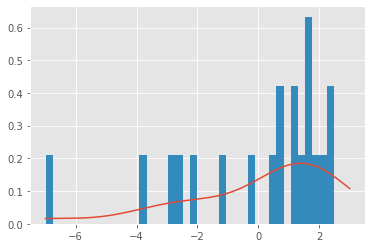

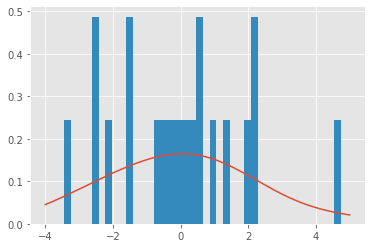

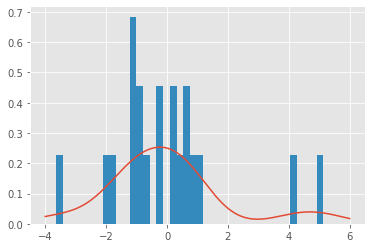

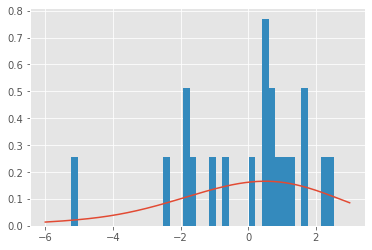

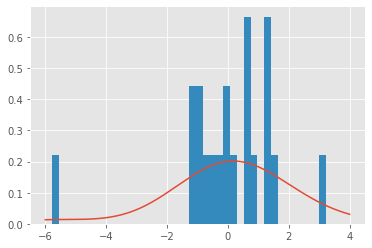

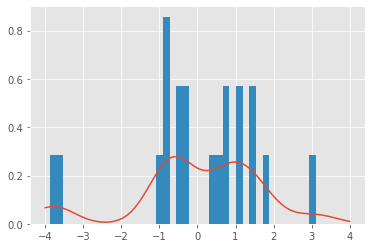

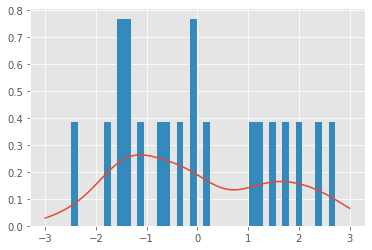

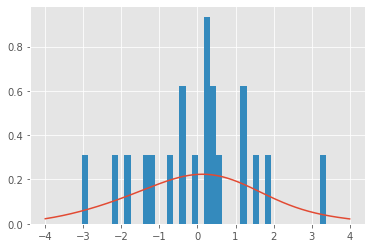

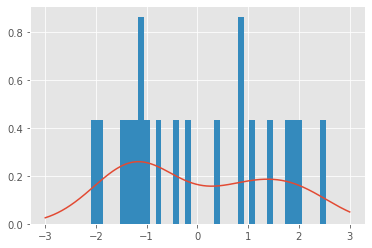

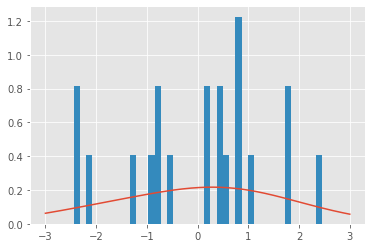

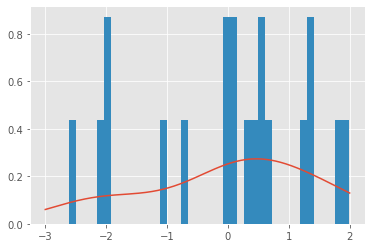

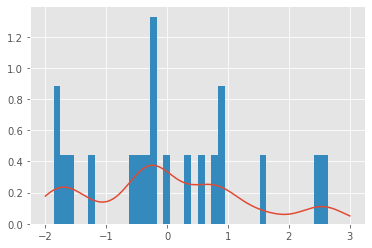

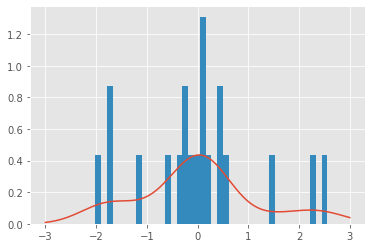

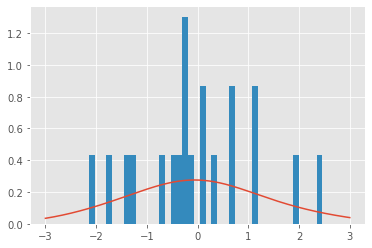

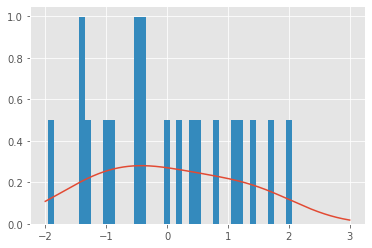

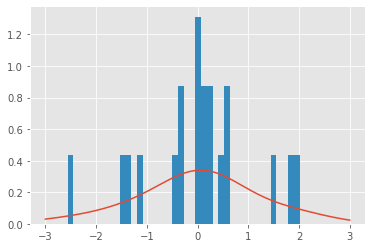

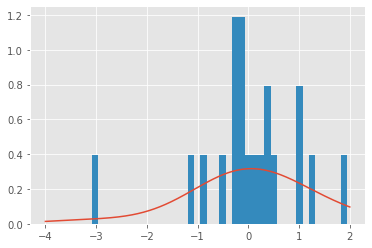

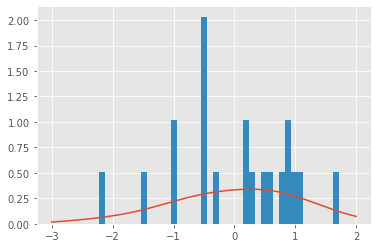

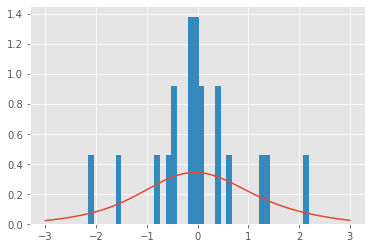

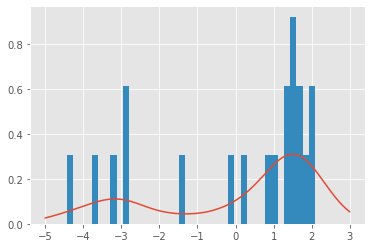

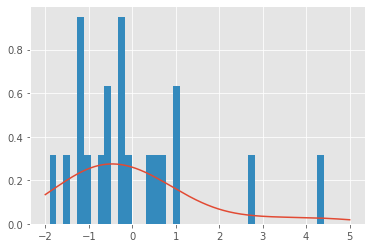

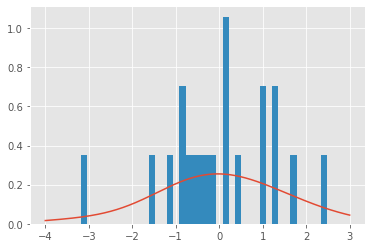

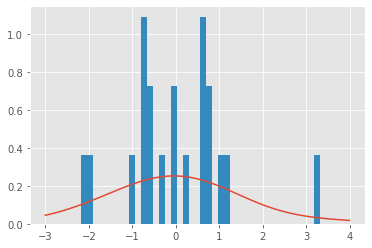

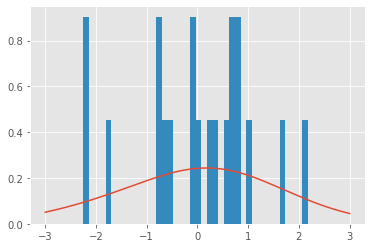

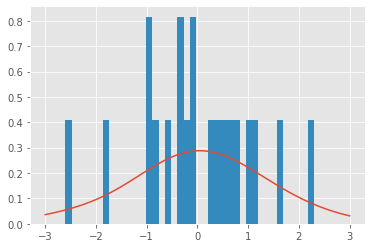

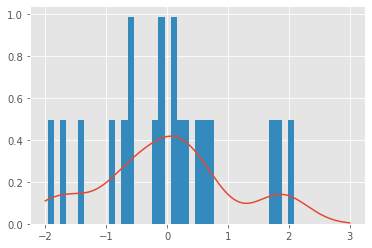

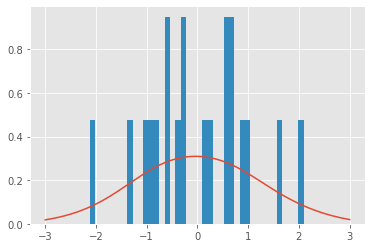

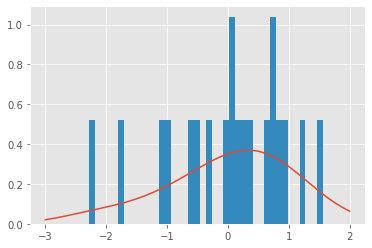

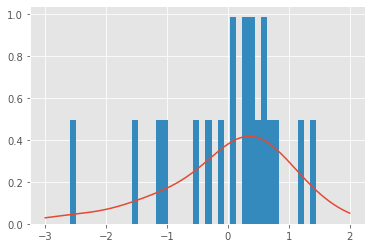

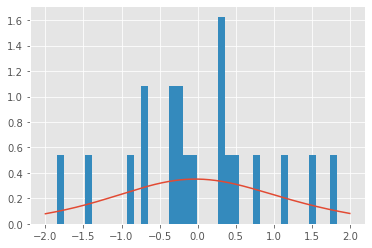

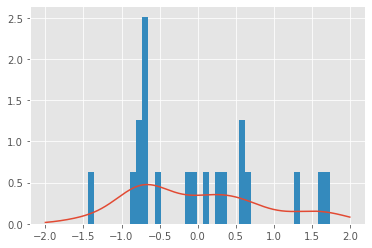

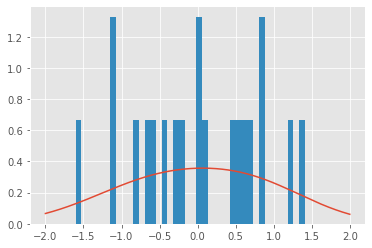

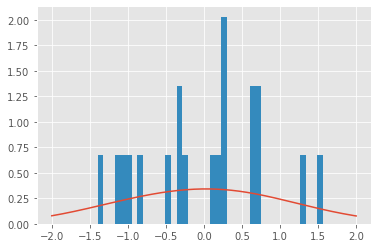

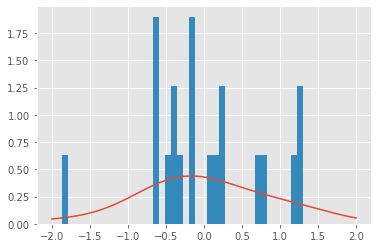

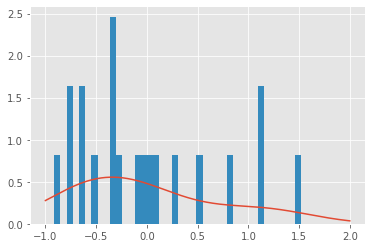

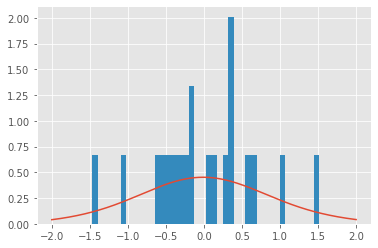

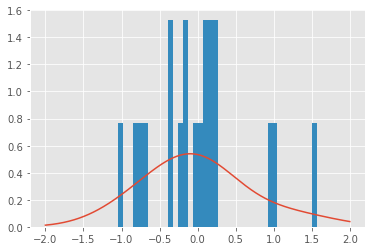

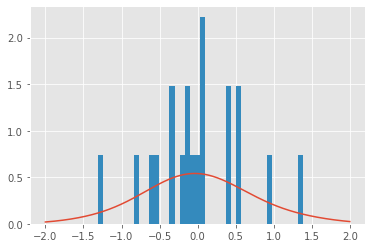

In [42]:
gen_num = 365
gen_fn, gen_gam, gen_f, gen_f2 = demand_generation(gen_num,residential_vpca,residential_hpca)

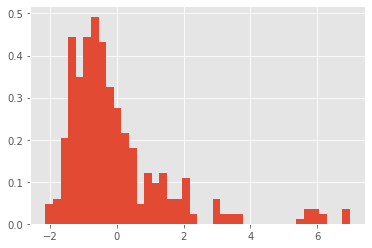

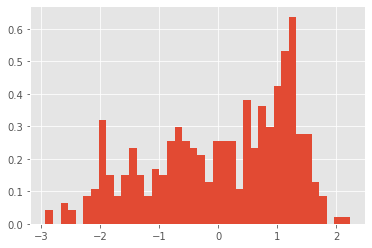

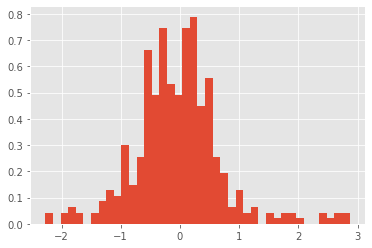

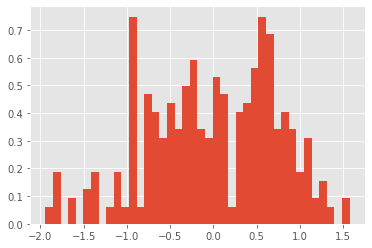

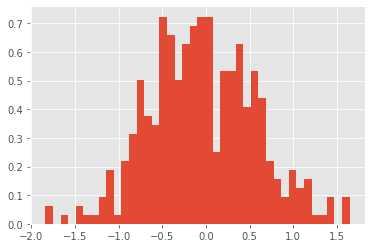

In [54]:
for i in range(0,vpca_samples.shape[1]):
    plt.figure()
    plt.hist(vpca_samples[:,i], density=True, bins=40);

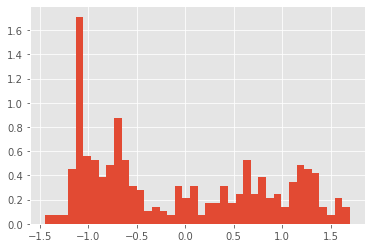

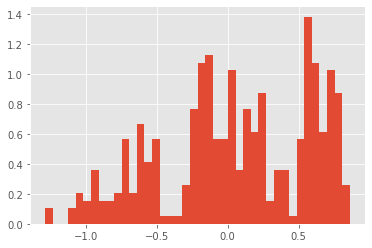

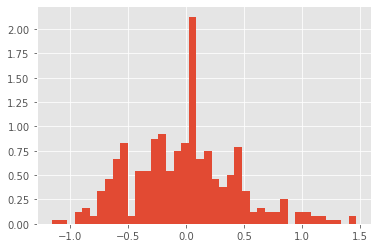

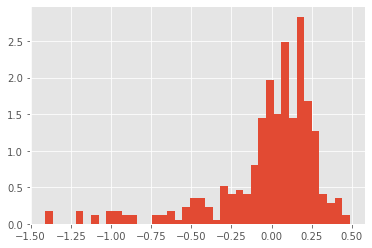

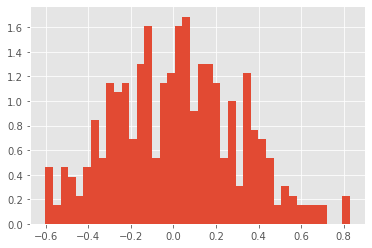

In [55]:
for i in range(0,hpca_samples.shape[1]):
    plt.figure()
    plt.hist(hpca_samples[:,i], density=True, bins=40);

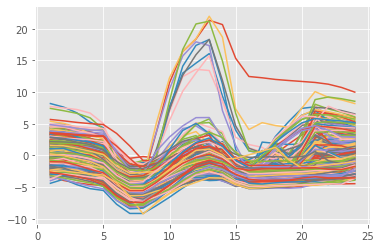

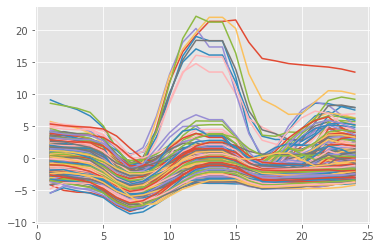

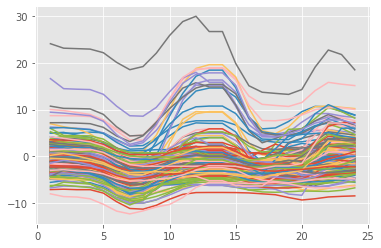

In [169]:
#Plot original fn
plt.figure(901)
for i in range(0,nsample):
    plt.plot(time,o_fn[:,i])

#Plot recovered fn
plt.figure(902)
for i in range(0,nsample):
    plt.plot(time,f_s[:,i])

#Plot generated fn
plt.figure(903)
for i in range(0,gen_num):
    plt.plot(time,gen_fn[:,i])

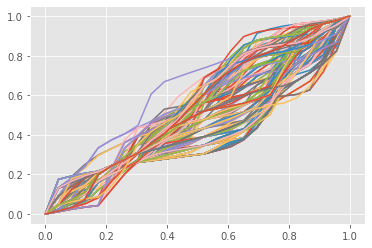

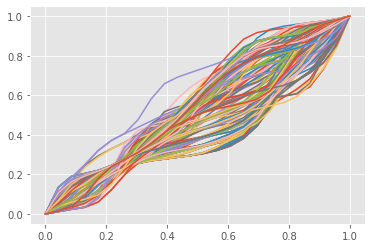

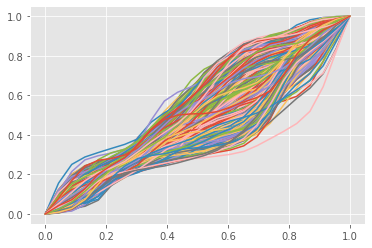

In [170]:
#Plot original gam
plt.figure(904)
for i in range(0,nsample):
    plt.plot(np.linspace(0,1,N),o_gam[:,i])

#Plot recovered gam
plt.figure(905)
for i in range(0,nsample):
    plt.plot(np.linspace(0,1,N),gams[:,i])

#Plot generated gam
plt.figure(906)
for i in range(0,gen_num):
    plt.plot(np.linspace(0,1,N),gen_gam[:,i])
plt.savefig('plots/gam_gen.png')

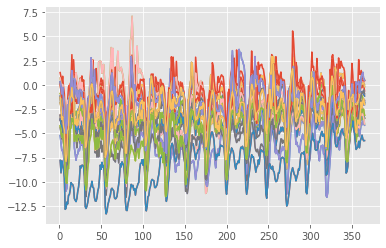

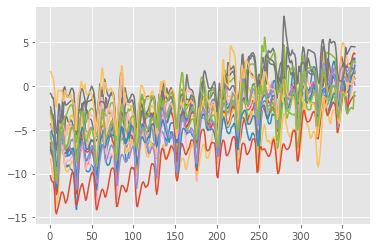

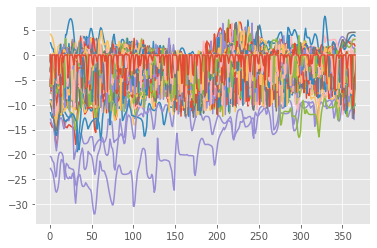

In [43]:
#Plot original f
plt.figure(907)
for i in range(0,nsample):
    plt.plot(time,o_f[:,i])

#Plot recovered ffor i in range(0,nsample):
    plt.plot(time,o_f[:,i])
plt.figure(908)
for i in range(0,nsample):
    plt.plot(time,f_rec[:,i])

#Plot generated f
plt.figure(909)
for i in range(0,gen_num):
    plt.plot(time,gen_f[:,i])

#Plot generated f2
#plt.figure(910)
#for i in range(0,gen_num):
#    plt.plot(time,gen_f2[:,i])

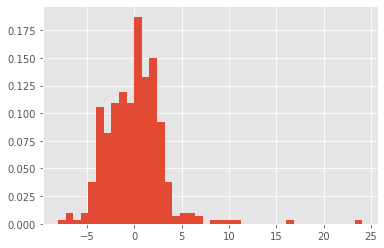

In [172]:
#print(gen_f[0,:])
plt.hist(gen_f[0,:], density=True, bins=40);